ctrnn implemented and modeled as a system of ordinary differential equations, with neuron potentials as the dependent variables.

The time evolution of the network is computed using the forward Euler method:

Recurrent means that there are cycles in the neurons. This can be the output being used as an input at the next time step or... A->B and B->A coming back around.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

#make pyplot text white
params = {"ytick.color" : "b",
          "xtick.color" : "b",
          "axes.labelcolor" : "b",
          "axes.edgecolor" : "b"}
plt.rcParams.update(params)

In [2]:
import random
import math

In [38]:
#A few helper functions representing a common activation function and its derivative
def sigmoid(x):
    if abs(x) > 100:
        print(x)
    return 1/(1 + math.exp(-x))

def sigmoid_derivative(s):
    return s * (1.0 - s)

It's actually a term "activation potential" that is value plugged into the actiavation function
1. If one does not want to ignore temporal summation, the sum of weighted inputs is used to drive a leaky RC tank circuit.
2. The output of that tank device is passed to the output/transfer function
3. https://en.wikipedia.org/wiki/Leaky_integrator
4. y is apparently the "activation_potential" referred to as both activation and potential

<h2>Leaky Integrator</h2>
<a href="https://en.wikipedia.org/wiki/Leaky_integrator">link</a>
<p>
    $\frac{dx}{dt} = -Ax + C$<br>
    where $A$ is a rate of 'leak' aka a time constant<br>
    where $C$ is the input<br>
    This gives the derivative<br>
    The derivative is useful because it gives the slope for a given point and therefore allows you to compute the next value<br>
</p>
<hr>

<h2>Applications of "Leaky Integrator" to Recursive Neurons</h2>
<p>
    $\frac{dx}{dt} = -Ax + C$<br>
    $\frac{da(x)}{dt} = -(1/\tau) * a(x) + \sum^{N}_{i=1}{w_{ij}x_j(t)}$<br>
    $-1/\tau$ is the rate of 'leak'<br>
    $a$ is the function to be derived<br>
    $\sum^{N}_{j=1}{w_{ij}x_j(t)}$ where j is the index of neurons from the previous layer, is the inputs for neuron i aka the "weighted input sum"
</p>
<hr>

<h2>Euler's Forward Method</h2>
<a href="http://fourier.eng.hmc.edu/e176/lectures/ch5/node3.html">link</a>
<p>
    This is an application of "Forward Euler's Method"<br>
    "Forward Euler's Method" finds the value of y after a given amount of time by taking steps along its slope<br>
    use derivative $y`(t)$ at the beginning of the interval $[t,t+h]$ to approximate $\Delta y = hy`(t)$<br>
    $y(t+h) ~= y(t) + hy`(t)$ where h is the size of the time step<br>
    This gives you an approximation of the value y at time t+h, but this value will only be accurate for smaller values of h<br>
    Therefore it is good practice to use "Euler's Forward Method" for multiple iterations for small values of h if you want to find y for a larger time into the future.
</p>
<hr>

<h2>Applying Euler's Forward Method to "Leaky Integrator" of Recursive Neuron</h2>
<p>
    $\frac{da(t)}{dt} = -(1/\tau) * a(t) + \sum^{N}_{i=1}{w_{ij}x_j(t)}$ found using "leaky integrator"<br>
    $a(t+h) ~= a(t) + h\frac{da(t)}{dt}$ found using "Euler's Forward Method"<br>
    $a(t+h) ~= a(t) + h*(-(1/\tau) * a(t) + \sum^{N}_{i=1}{w_{ij}x_j(t)})$<br>
    I guess we're also willing to assume that $a(0) == 0$<br>
    TODO: look further into this
</p>
<hr>

<h2>Using output of neuron for time $t+h$</h2>
<p>
    $y_i(t) = \Phi(a_i(t) - \theta_i)$ where $\Phi$ is the activation function and $\theta_i$ is the bias of the nueron<br>
    So we replace time $t$ with time $t+h$<br>
    $y_i(t+h) = \Phi(a_i(t+h) - \theta_i)$ as you can see the $a(t+h)$ we defined above if now found here<br>
    So we can just fill in the defintion we found above<br>
    $a(t+h) ~= a(t) + h*(-(1/\tau) * a(t) + \sum^{N}_{i=1}{w_{ij}x_j(t)})$<br>
    $y_i(t+h) = \Phi(... - \theta_i)$ where ... is the above line
</p>

In [111]:
#Takes the rate of 'loss' of a line, it's current value, and its input and finds an approx of the slope
def leaky_integrator(A, x, C):
    return (-A) * x + C

#Returns an approximation of the value of a lone after time "time_step"
def forward_euler_method(time_step, slope, value):
    return value + time_step * slope

class HopfieldRecurrentNeuron(object):
    def __init__(self, input_count, tau=1.0, bias=0.0):
        self.tau = tau #it's used later as 1/tau so higher values of tau causer more leakage
        self.weights = [random.random() for i in range(input_count)]
        self.prev_activation = 0 #assumed a(0) = 0
        self.bias = bias
    
    @property
    def tau(self):
        return self.__tau
    
    @tau.setter
    def tau(self, tau_val):
        self.__tau = tau_val
        self.leak_rate = 1 / tau_val #defines it upon updating the bias rather than each time it needs to be used
    
    def get_output(self, input_values, time_step=0.0):
        input_sum = sum([self.weights[i] * input_values[i] for i in range(len(input_values))])
        
        activation_slope_approx = leaky_integrator(self.leak_rate, self.prev_activation, input_sum)
        activation = forward_euler_method(time_step, activation_slope_approx, self.prev_activation)
        
        output = sigmoid(activation - self.bias)
        
        self.prev_activation = activation
        return output

In [120]:
neuron = HopfieldRecurrentNeuron(1, 3, 0.0)
for i in range(100):
    print(neuron.get_output([0], 1))
print(sigmoid(0))

0.5


In [112]:
n = HopfieldRecurrentNeuron(1, 2.8, 2.0)

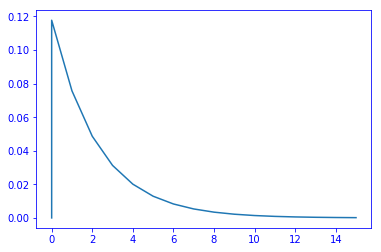

In [113]:
#this is the graph the neural activation as time passes, when an input is only given as an instantenous input at t=0
x = []
y = []

#This makes it look more like the graph from the book
x.append(0)
y.append(0)

x.append(0)
n.get_output([1], time_step=1)
y.append(n.prev_activation)
for i in range(15):
    #print(n.test_input([0], time_step=1))
    x.append(i+1)
    n.get_output([0], time_step=1)
    y.append(n.prev_activation)
    
plt.plot(x,y)
#It approches 0 as the value goes on because the leak causes a slow degradation as no input is added

In [110]:
class CTRNeuralNetwork(object):
    def __init__(self, layer_size_ls):
        #Create layers with inputs the size of the previous layers output count
        self.layers = []
        for i in range(1, len(layer_size_ls)):
            layer_size = layer_size_ls[i]
            prev_layer_size = layer_size_ls[i-1]
            
            #Each layer is represented by a list of neurons of a size with inputs large enough for the previous layer
            self.layers.append([HopfieldRecurrentNeuron(prev_layer_size) for i in range(layer_size)]) 
    
    def advance(self, inputs, time_step):
        layer_output = inputs
        for layer in self.layers:
            layer_output = [neuron.get_output(layer_output, time_step=time_step) for neuron in layer]
        return layer_output
    
    @staticmethod
    def network_from_genome(genome, layer_size_ls):
        #we're only going to evolve the network parameterers
        #each set of 3 values in the genome is a neuron
        n = CTRNeuralNetwork(layer_size_ls)
        k = 0
        for i in range(len(n.layers)):
            layer = n.layers[i]
            for j in range(len(layer)):
                neuron = layer[j]
                
                neuron.bias = genome[k+0]
                neuron.tau = genome[k+1]
                neuron.weights = genome[k+2: k+2+len(neuron.weights)]
                
                
                k += len(neuron.weights) + 2
        
        return n

In [84]:
from GeneticAlgorithm import *
from tqdm import tqdm_notebook

#make the individual
class NetworkIndividual(AbstractLinkedListIndividual):
    def __init__(self):
        self.layer_size_ls = [6, 5, 6] #All characters of alphabet as input and output
        
        #Encode neurons as a list of their values
        self.genotype = []
        for i in range(1, len(self.layer_size_ls)):
            prev_layer_size = self.layer_size_ls[i-1]
            layer_size = self.layer_size_ls[i]
            
            for i in range(layer_size):
                self.genotype.append(random.random()) #bias
                self.genotype.append(random.random() * 50) #tau
                self.genotype.extend([random.random() for i in range(prev_layer_size)]) #weights for neuron_i
                #Should be -1 + random.random()*2
        
    def mutate(self, mutation_rate):
        for i in range(len(self.genotype)):
            if random.random() < mutation_rate:
                self.genotype[i] = random.random()
    
    def fitness(self):
        n = CTRNeuralNetwork.network_from_genome(self.genotype, self.layer_size_ls)
        sequence = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0]
        max_val = max(sequence)
        encoded_sequence = [[(j is value) for j in range(max_val+1)] for value in sequence]
        
        total_error = 0.0
        for i in range(len(encoded_sequence)-1):
            this_value = encoded_sequence[i]
            next_value = encoded_sequence[i+1]
            
            output = n.advance(this_value, 0.0000001)
            #Squared error
            
            total_error += sum((next_value[i]-output[i])**2 for i in range(len(output)))
        
        return -total_error #Uses a negative because this network is built to optimize for higher values
            
            
    
"""def print_best_performing(pop):
    hf = pop.highest_fitness_individual
    n = CTRNeuralNetwork.network_from_genome(hf.genotype, hf.layer_size_ls)
    print(n.advance([0,0,1,0,0,0], 0.1))    
    
pop = TournamentPopulation(NetworkIndividual, 1000)
#pop.run_cycle()
print(pop.highest_fitness_individual)
print(pop.highest_fitness)
for i in tqdm_notebook(range(100000)):
    if i % 1000 == 0:
        print_best_performing(pop)
    pop.run_cycle()
    
print(pop.highest_fitness_individual)
print(pop.highest_fitness)
print_best_performing(pop)"""

'def print_best_performing(pop):\n    hf = pop.highest_fitness_individual\n    n = CTRNeuralNetwork.network_from_genome(hf.genotype, hf.layer_size_ls)\n    print(n.advance([0,0,1,0,0,0], 0.1))    \n    \npop = TournamentPopulation(NetworkIndividual, 1000)\n#pop.run_cycle()\nprint(pop.highest_fitness_individual)\nprint(pop.highest_fitness)\nfor i in tqdm_notebook(range(100000)):\n    if i % 1000 == 0:\n        print_best_performing(pop)\n    pop.run_cycle()\n    \nprint(pop.highest_fitness_individual)\nprint(pop.highest_fitness)\nprint_best_performing(pop)'

In [85]:
print(hf.genotype)

NameError: name 'hf' is not defined

In [86]:
for i in range(20):
    print(-1 + random.random()*2)

0.3122191419848097
-0.8974459244211797
-0.42039929738767645
-0.1283477663954602
-0.5226340497459268
0.4320927636193508
0.33117694702578593
-0.9769233407229452
-0.7722902843288053
-0.017723772742728183
-0.7606029162851151
0.869953178193416
0.4462728035312773
-0.5745037768614616
0.4648293303490101
0.252084862571867
-0.9304779137802393
-0.4149289141975836
-0.6084998168529594
0.5993832472209306


In [94]:
n = CTRNeuralNetwork([2, 2, 1])
n.layers[0][0].weights = [1, 1] #left hidden
n.layers[0][0].bias = 0.5

n.layers[0][1].weights = [-1, -1] #right hidden
n.layers[0][1].bias = -1.5

n.layers[1][0].weights = [1, 1] #output
n.layers[1][0].bias = 1.5

print(n.advance([0,0], 1))
print(n.advance([0,0], 1))
print(n.advance([0,0], 1))
print(n.advance([0,0], 1))
print(n.advance([0,0], 1))
print(n.advance([0,1], 1))
print(n.advance([1,0], 1))
print(n.advance([1,1], 1))
print(n.advance([1,1], 1))
print(n.advance([1,1], 1))
print(n.advance([1,1], 1))
print(n.advance([1,1], 1))

[0.42436377623451826]
[0.42436377623451826]
[0.42436377623451826]
[0.42436377623451826]
[0.42436377623451826]
[0.4365732064532725]
[0.4365732064532725]
[0.42436377623451826]
[0.42436377623451826]
[0.42436377623451826]
[0.42436377623451826]
[0.42436377623451826]
